In [30]:
import sys ; sys.path.append('../')
from lnos.observer.lueneberger import LuenebergerObserver
from lnos.datasets.plot import plotLogError2D, plotTrajectory2D
from scipy import signal
import math
import numpy as np
import torch
from torch.autograd import Variable

In [17]:
# Define plant dynamics
def f(x): return torch.cat((torch.reshape(torch.pow(x[1, :], 3), (1, -1)), torch.reshape(-x[0, :], (1, -1))), 0)
def h(x): return torch.reshape(x[0, :], (1, -1))
def g(x): return torch.zeros(x.shape[0], x.shape[1])
def u(x): return 0

In [18]:
# System dimension
dim_x = 2
dim_y = 1

# Initiate observer with system dimensions
observer = LuenebergerObserver(dim_x, dim_y, f, g, h, u)

# Eigenvalues for D 
b, a = signal.bessel(3, 2*math.pi, 'low', analog=True, norm='phase')
eigen = np.roots(a)

# Set system dynamics
observer.D = observer.tensorDFromEigen(eigen)
observer.F = torch.tensor([[1.0], [1.0], [1.0]])

In [19]:
# TODO find nicer solution
net = np.arange(-1,1,0.05)
mesh = np.array(np.meshgrid(net,net))
combinations = mesh.T.reshape(-1, 2)
comb = torch.tensor(combinations)

In [20]:
# Generate training data
train_data = observer.generateTrainingData(comb)

../lnos/observer/lueneberger.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((torch.tensor(x_dot), z_dot))


In [26]:
T_star = observer.computeNonlinearLuenbergerTransformation(train_data, False, 20, 2)

[1,   200] loss: 0.253
[1,   400] loss: 0.180
[1,   600] loss: 0.169
[1,   800] loss: 0.165
====> Epoch: 1 done!
[2,   200] loss: 0.174
[2,   400] loss: 0.157
[2,   600] loss: 0.154
[2,   800] loss: 0.155
====> Epoch: 2 done!
[3,   200] loss: 0.112
[3,   400] loss: 0.058
[3,   600] loss: 0.044
[3,   800] loss: 0.039
====> Epoch: 3 done!
[4,   200] loss: 0.039
[4,   400] loss: 0.036
[4,   600] loss: 0.040
[4,   800] loss: 0.038
====> Epoch: 4 done!
[5,   200] loss: 0.031
[5,   400] loss: 0.036
[5,   600] loss: 0.037
[5,   800] loss: 0.037
====> Epoch: 5 done!
[6,   200] loss: 0.034
[6,   400] loss: 0.034
[6,   600] loss: 0.033
[6,   800] loss: 0.031
====> Epoch: 6 done!
[7,   200] loss: 0.032
[7,   400] loss: 0.029
[7,   600] loss: 0.026
[7,   800] loss: 0.027
====> Epoch: 7 done!
[8,   200] loss: 0.022
[8,   400] loss: 0.022
[8,   600] loss: 0.019
[8,   800] loss: 0.017
====> Epoch: 8 done!
[9,   200] loss: 0.016
[9,   400] loss: 0.015
[9,   600] loss: 0.015
[9,   800] loss: 0.013
====

In [31]:
# Simulation parameters for ODE
tsim = (0,50)
dt = 1e-2

# Compute test data
w0_test = torch.tensor([[np.random.uniform(-1,1)], [np.random.uniform(-1,1)],[0],[0],[0]], dtype=torch.double)
tq_test, w_test = observer.simulateLueneberger(w0_test, tsim, dt)

# Data pipeline x_hat
input = w_test.reshape(w_test.shape[0], w_test.shape[1]).float()
input = Variable(input[:,2:])

# Sample data from T*
x_hat = observer.T_star(input)
x_hat = x_hat.detach().numpy()

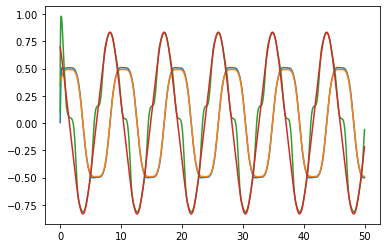

In [33]:
import matplotlib.pyplot as plt
# Plot x_1
plt.plot(tq_test, x_hat[:,0])
plt.plot(tq_test, w_test[:,0])

# Plot x_2
plt.plot(tq_test, x_hat[:,1])
plt.plot(tq_test, w_test[:,1])
plt.show()